In [1]:
import pywt
import numpy as np 
import pandas as pd


In [2]:
df  = pd.read_csv(r'C:\Users\abusu\Desktop\BME\ProJect64\ProJect64 System Architect\Data\Rel_Data\1_10-27-42_acc.csv')

In [3]:
df

,t,az
0,2.60,4278
1,4.58,4290
2,6.55,4282
3,8.53,4266
4,10.50,4282
...,...,...
15168,29991.72,4224
15169,29993.70,4262
15170,29995.70,4284
15171,29997.68,4258


In [4]:
from matplotlib import pyplot as plt



0.5058163040677439

In [24]:
fs = 276
time = np.arange(0, len(df), 1/fs)

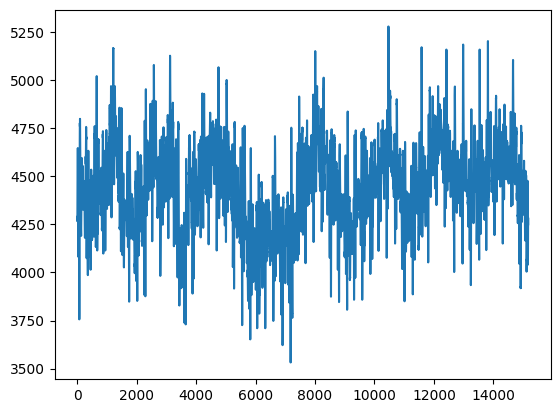

In [5]:
plt.plot(df["az"], label='x')

plt.show()

In [6]:
wavelet = 'db4'
level = 4
coeffs = pywt.wavedec(df["az"], wavelet, level=level)


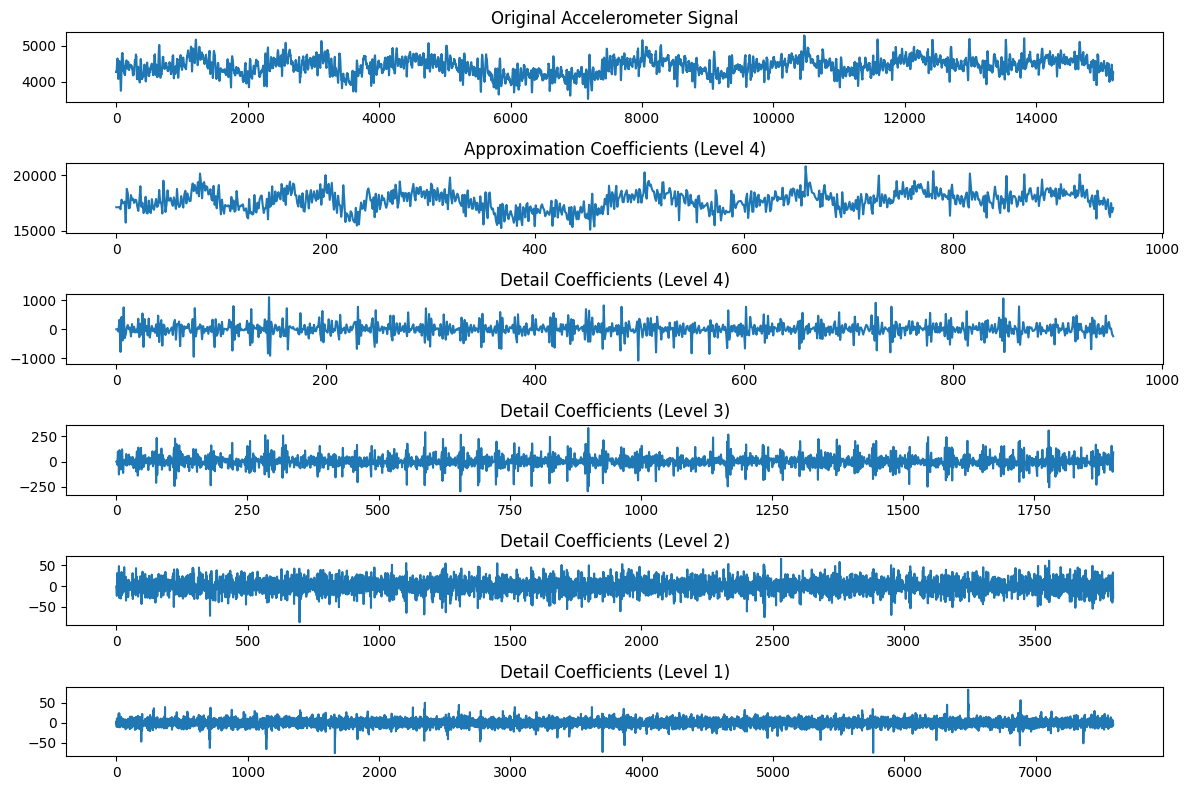

In [9]:
plt.figure(figsize=(12, 8))

# Plot original signal
plt.subplot(level + 2, 1, 1)
plt.plot( df["az"], label='Original Signal')
plt.title('Original Accelerometer Signal')

# Plot wavelet coefficients
for i, coef in enumerate(coeffs):
    plt.subplot(level + 2, 1, i + 2)
    plt.plot(coef)
    if i == 0:
        plt.title(f'Approximation Coefficients (Level {level})')
    else:
        plt.title(f'Detail Coefficients (Level {level - i + 1})')

plt.tight_layout()
plt.show()


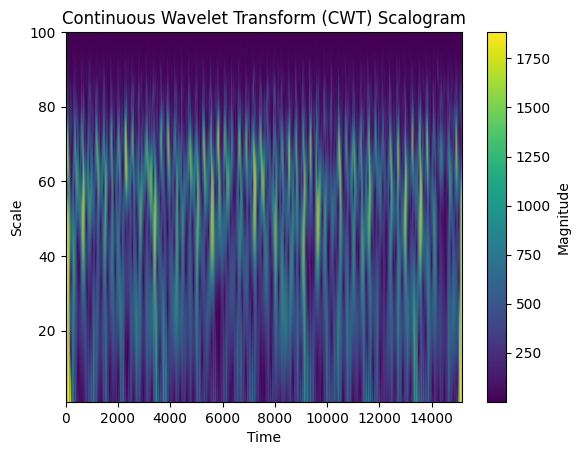

In [12]:
scales = np.arange(1, 100)
cwtmatr, freqs = pywt.cwt(df['az'], scales, 'morl')  # Morlet is a good wavelet for CWT

plt.imshow(np.abs(cwtmatr), extent=[0, len(df['az']), 1, 100], cmap='viridis', aspect='auto',
           vmax=np.percentile(np.abs(cwtmatr), 99))
plt.title("Continuous Wavelet Transform (CWT) Scalogram")
plt.ylabel("Scale")
plt.xlabel("Time")
plt.colorbar(label='Magnitude')
plt.show()


In [14]:
print("The ew")

The ew


Calculated Threshold: 1.8022


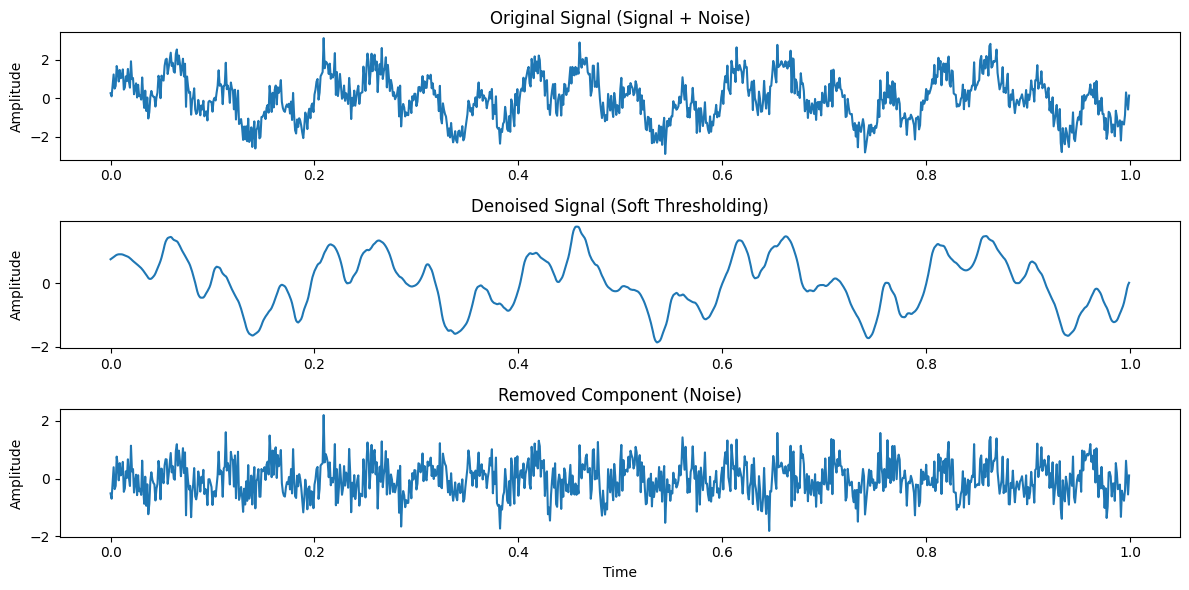

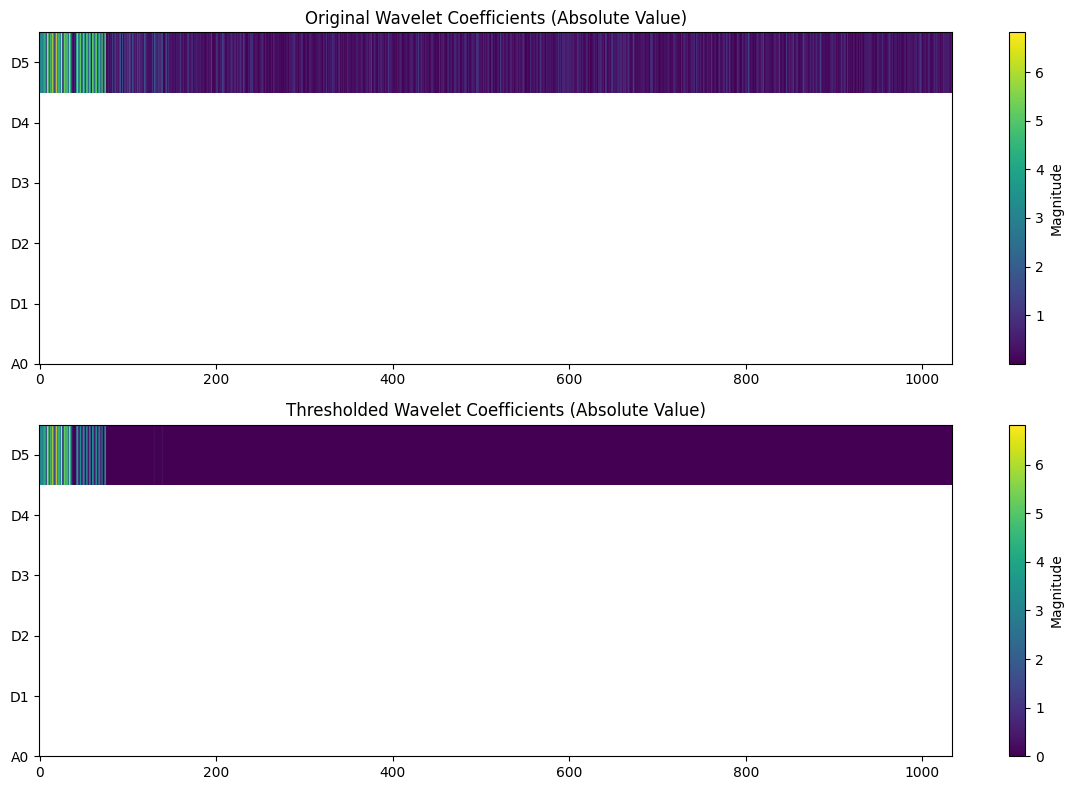

In [20]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate a sample signal with some noise
np.random.seed(42)
time = np.linspace(0, 1, 1000, endpoint=False)
signal = (np.sin(2 * np.pi * 5 * time) +
          np.sin(2 * np.pi * 20 * time) +
          np.random.randn(len(time)) * 0.5) # Signal + Noise

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time, signal)
plt.title('Original Signal (Signal + Noise)')
plt.ylabel('Amplitude')

# 2. Choose a wavelet and decomposition level
wavelet = 'db4' # Daubechies 4 is a common choice for denoising
level = 5      # Number of decomposition levels

# Get the maximum possible level for the given signal length and wavelet
max_level = pywt.dwt_max_level(len(signal), wavelet)
if level > max_level:
    print(f"Warning: Chosen level {level} exceeds max possible {max_level}. Using {max_level}.")
    level = max_level

# 3. Perform the Discrete Wavelet Transform (DWT)
coeffs = pywt.wavedec(signal, wavelet, level=level)

# 4. Determine a Threshold (Crucial Step for "Flatting Down")
sigma = np.median(np.abs(coeffs[-1])) / 0.6745
threshold = sigma * np.sqrt(2 * np.log(len(signal)))

print(f"Calculated Threshold: {threshold:.4f}")

# 5. Apply Thresholding to Detail Coefficients
denoised_coeffs = list(coeffs) # Make a copy as a list to modify

for i in range(1, len(denoised_coeffs)): # Iterate through detail coefficients (index 1 to end)
    denoised_coeffs[i] = pywt.threshold(denoised_coeffs[i], value=threshold, mode='soft')

# 6. Reconstruct the Denoised Signal
denoised_signal = pywt.waverec(denoised_coeffs, wavelet)

# Trim to the original signal length if necessary.
if len(denoised_signal) > len(signal):
    denoised_signal = denoised_signal[:len(signal)]
elif len(denoised_signal) < len(signal):
    print("Warning: Reconstructed signal is shorter than original. Check padding/signal length.")


# 7. Plot the results
plt.subplot(3, 1, 2)
plt.plot(time, denoised_signal)
plt.title('Denoised Signal (Soft Thresholding)')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(time, signal - denoised_signal)
plt.title('Removed Component (Noise)')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


# Corrected Visualization of the coefficients (optional)
plt.figure(figsize=(12, 8))

# --- Original Coefficients ---
ax1 = plt.subplot(2, 1, 1)
data_original, slices_original = pywt.coeffs_to_array(coeffs)

# Check the shape and handle potential 1D array issue
if data_original.ndim == 1:
    # If it's 1D, reshape it into a 2D array (e.g., as a single row)
    data_original = data_original.reshape(1, -1)
    print("Warning: Original coefficients array was 1D, reshaped for imshow.")
elif data_original.ndim == 0: # This case is unlikely but good to handle
    print("Error: Original coefficients array is 0D. Cannot display.")
    data_original = np.array([[0]]) # Fallback to a dummy 2D array

plt.imshow(np.abs(data_original), aspect='auto', cmap='viridis')
plt.title('Original Wavelet Coefficients (Absolute Value)')
plt.colorbar(label='Magnitude')
ax1.set_yticks(np.arange(len(slices_original)))
ax1.set_yticklabels([f'D{i}' for i in range(len(slices_original) - 1, 0, -1)] + ['A0']) # Label levels

# --- Thresholded Coefficients ---
ax2 = plt.subplot(2, 1, 2)
data_denoised, slices_denoised = pywt.coeffs_to_array(denoised_coeffs)

if data_denoised.ndim == 1:
    data_denoised = data_denoised.reshape(1, -1)
    print("Warning: Denoised coefficients array was 1D, reshaped for imshow.")
elif data_denoised.ndim == 0:
    print("Error: Denoised coefficients array is 0D. Cannot display.")
    data_denoised = np.array([[0]])

plt.imshow(np.abs(data_denoised), aspect='auto', cmap='viridis')
plt.title('Thresholded Wavelet Coefficients (Absolute Value)')
plt.colorbar(label='Magnitude')
ax2.set_yticks(np.arange(len(slices_denoised)))
ax2.set_yticklabels([f'D{i}' for i in range(len(slices_denoised) - 1, 0, -1)] + ['A0']) # Label levels

plt.tight_layout()
plt.show()